# 相似地址发现 - erc20-usdt


## 问题定义

和 [相似地址发现](https://github.com/rayhopf/bxgu/blob/main/notes/240824_find_similar_address_v001.md) 里类似

## 获取数据
从 dune 取最近几个月 `erc20-usdt` 的交易记录

```sql
/* Aggregate the data by (shortened) from and to addresses, and concatenate into a single string */
WITH relevant_transfers /* Filter for relevant transfers (USDT ERC20 after 2024-08-01) */ AS (
  SELECT
    "from",
    "to",
    value / 1e6 AS value_decimal /* Adjusting for decimal places to treat as regular floats */
  FROM erc20_ethereum.evt_transfer
  WHERE
    contract_address = FROM_HEX('dac17f958d2ee523a2206206994597c13d831ec7')
    AND evt_block_time > TRY_CAST('2024-01-01 00:00' AS TIMESTAMP)
    AND evt_block_time < TRY_CAST('2024-09-01 00:00' AS TIMESTAMP)
    AND value > 1e10 /* only choose 10k+ usdt */
)
SELECT
  CONCAT_WS(
    ';',
    TRY_CAST("from" AS VARCHAR),
    TRY_CAST("to" AS VARCHAR),
    TRY_CAST(COUNT(*) AS VARCHAR) /* Count of transactions between each (from, to) pair */,
    TRY_CAST(SUM(value_decimal) AS VARCHAR) /* Total amount transferred between each (from, to) pair */
  ) AS from_to_count_amount
FROM relevant_transfers
GROUP BY
  "from",
  "to"
HAVING
  SUM(value_decimal) > 100000 /* Filter where the total amount is greater than 100000 */
ORDER BY
  SUM(value_decimal) DESC /* Optional: order by the total amount in descending order */

```

`01J6RNZNPCBAPA7HMZ7AE9CCHQ.csv`


本来是要取 4 列的 `(from, to, count, amount)`，但是 dune 是按数据点个数 (`N_row * N_col`)扣费的，所以我们取的时候把所以列聚合成 1 列，这样能把费用降到 `1/N_col`

In [1]:
!gdown "132a8Ff2s-AlDtvVzJ6HGo49Iv70knGy3"
!ls

Downloading...
From: https://drive.google.com/uc?id=132a8Ff2s-AlDtvVzJ6HGo49Iv70knGy3
To: /content/01J6RNZNPCBAPA7HMZ7AE9CCHQ.csv
100% 43.1M/43.1M [00:02<00:00, 18.8MB/s]
01J6RNZNPCBAPA7HMZ7AE9CCHQ.csv	sample_data


In [2]:
import pandas as pd
df = pd.read_csv("01J6RNZNPCBAPA7HMZ7AE9CCHQ.csv")
df[['from', 'to', 'count', 'amount']] = df['from_to_count_amount'].str.split(';', expand=True)
df['count'] = df['count'].astype(int)
df['amount'] = df['amount'].astype(float)
df = df.drop(columns=['from_to_count_amount'])
df.head()

,from,to,count,amount
0,0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4,0x28c6c06298d514db089934071355e5743bf21d60,4739,2.623253e+10
1,0x28c6c06298d514db089934071355e5743bf21d60,0x56eddb7aa87536c09ccc2793473599fd21a8b17f,476,2.425379e+10
2,0x28c6c06298d514db089934071355e5743bf21d60,0x21a31ee1afc51d94c2efccaa2092ad1028285549,460,2.380528e+10
3,0x28c6c06298d514db089934071355e5743bf21d60,0xdfd5293d8e347dfe59e90efd55b2956a1343963d,452,2.200092e+10
4,0x28c6c06298d514db089934071355e5743bf21d60,0x9696f59e4d72e237be84ffd425dcad154bf96976,425,2.072906e+10


## 处理特征

In [3]:

# 1. Send Count and Send Amount
send_stats = df.groupby('from').agg(
    send_count=('count', 'sum'),
    send_amount=('amount', 'sum'),
    send_degree=('to', 'nunique')
)

# 2. Receive Count and Receive Amount
receive_stats = df.groupby('to').agg(
    receive_count=('count', 'sum'),
    receive_amount=('amount', 'sum'),
    receive_degree=('from', 'nunique')
)

# 3. Merge Send and Receive DataFrames
full_stats = pd.merge(send_stats, receive_stats, how='outer', left_index=True, right_index=True).fillna(0)

# 4. All Count, All Amount, All Degree
full_stats['all_count'] = full_stats['send_count'] + full_stats['receive_count']
full_stats['all_amount'] = full_stats['send_amount'] + full_stats['receive_amount']
full_stats['all_degree'] = full_stats['send_degree'] + full_stats['receive_degree']

full_stats['send_count_ratio'] = full_stats['send_count'] / full_stats['all_count']
full_stats['send_amount_ratio'] = full_stats['send_amount'] / full_stats['all_amount']
full_stats['send_degree_ratio'] = full_stats['send_degree'] / full_stats['all_degree']
full_stats['receive_count_ratio'] = full_stats['receive_count'] / full_stats['all_count']
full_stats['receive_amount_ratio'] = full_stats['receive_amount'] / full_stats['all_amount']
full_stats['receive_degree_ratio'] = full_stats['receive_degree'] / full_stats['all_degree']

# The final DataFrame `full_stats` contains all the features.
full_stats = full_stats.reset_index().rename(columns={'index': 'address'})
full_stats

,address,send_count,send_amount,send_degree,receive_count,receive_amount,receive_degree,all_count,all_amount,all_degree,send_count_ratio,send_amount_ratio,send_degree_ratio,receive_count_ratio,receive_amount_ratio,receive_degree_ratio
0,0x000000000000232e765d898b5f1b189b5c993f05,12.0,7.818178e+05,4.0,14.0,8.753352e+05,4.0,26.0,1.657153e+06,8.0,0.461538,0.471784,0.5000,0.538462,0.528216,0.5000
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,58.0,7.239166e+06,9.0,55.0,7.054814e+06,7.0,113.0,1.429398e+07,16.0,0.513274,0.506449,0.5625,0.486726,0.493551,0.4375
2,0x000000000000bb1b11e5ac8099e92e366b64c133,15.0,6.663513e+05,2.0,15.0,6.663513e+05,2.0,30.0,1.332703e+06,4.0,0.500000,0.500000,0.5000,0.500000,0.500000,0.5000
3,0x0000000000237f19e13cfdf1aa8268e4084494a2,34.0,9.895668e+06,12.0,45.0,1.273625e+07,3.0,79.0,2.263192e+07,15.0,0.430380,0.437244,0.8000,0.569620,0.562756,0.2000
4,0x000000000035b5e5ad9019092c665357240f594e,6.0,1.375851e+06,1.0,6.0,1.375851e+06,1.0,12.0,2.751702e+06,2.0,0.500000,0.500000,0.5000,0.500000,0.500000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200288,0xfffe4448e5a50a36a956b99b7e234672ea189267,110.0,3.754643e+06,3.0,8.0,3.760000e+06,2.0,118.0,7.514643e+06,5.0,0.932203,0.499644,0.6000,0.067797,0.500356,0.4000
200289,0xfffed4874432715ada21a072aca813d9a43ee186,2.0,2.101990e+05,1.0,4.0,2.101990e+05,1.0,6.0,4.203980e+05,2.0,0.333333,0.500000,0.5000,0.666667,0.500000,0.5000
200290,0xfffedfdfb583b6b3d945a3128c75dee6beba3a78,3.0,3.267260e+05,1.0,3.0,4.378700e+05,1.0,6.0,7.645960e+05,2.0,0.500000,0.427318,0.5000,0.500000,0.572682,0.5000
200291,0xffffd1eb5a15ceb74d81f5c6097353a1056039c7,4.0,1.362242e+05,1.0,6.0,1.552483e+05,1.0,10.0,2.914725e+05,2.0,0.400000,0.467366,0.5000,0.600000,0.532634,0.5000


## 特征归一化

与 [相似地址发现](https://github.com/rayhopf/bxgu/blob/main/notes/240824_find_similar_address_v001.md) 的特征归一化方法（min-max）不同，这里用的 `quantile` 归一化方法。

In [4]:

# Assuming `full_stats` is your dataframe from the previous answer
# Specify columns that require rank percent calculation
columns_to_rank = [
    'send_count', 'send_amount', 'send_degree',
    'receive_count', 'receive_amount', 'receive_degree',
    'all_count', 'all_amount', 'all_degree',
]

columns_not_to_rank = [
    'send_count_ratio',
    'send_amount_ratio',
    'send_degree_ratio',
    'receive_count_ratio',
    'receive_amount_ratio',
    'receive_degree_ratio'
]

# Calculate rank and rank percent for each column
rank_percent_df = full_stats.copy()  # Make a copy of the original DataFrame to store rank percent values

for col in columns_to_rank:
    # Rank in descending order (highest value gets highest rank)
    rank_percent_df[f'{col}_rank'] = rank_percent_df[col].rank(ascending=False)

    # Total number of rows (used to calculate rank percent)
    total_records = len(rank_percent_df)

    # Calculate rank percent (rank / total_records)
    rank_percent_df[f'{col}_rank_percent'] = rank_percent_df[f'{col}_rank'] / total_records

# Display rank percent
display_columns = [f'{col}_rank_percent' for col in columns_to_rank] + columns_not_to_rank
df2 = rank_percent_df[['address'] + display_columns]
df2 = df2.sort_values(['all_amount_rank_percent'])
df2 = df2.reset_index(drop=True)
df2.head()

,address,send_count_rank_percent,send_amount_rank_percent,send_degree_rank_percent,receive_count_rank_percent,receive_amount_rank_percent,receive_degree_rank_percent,all_count_rank_percent,all_amount_rank_percent,all_degree_rank_percent,send_count_ratio,send_amount_ratio,send_degree_ratio,receive_count_ratio,receive_amount_ratio,receive_degree_ratio
0,0x28c6c06298d514db089934071355e5743bf21d60,0.000075,0.000005,0.000025,0.000005,0.000005,0.000005,0.000010,0.000005,0.000005,0.142145,0.505793,0.220421,0.857855,0.494207,0.779579
1,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,0.000030,0.000010,0.000050,0.000055,0.000010,0.000010,0.000035,0.000010,0.000010,0.629408,0.499127,0.326004,0.370592,0.500873,0.673996
2,0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40,0.000035,0.000015,0.000035,0.000050,0.000015,0.000020,0.000045,0.000015,0.000020,0.556583,0.496996,0.518119,0.443417,0.503004,0.481881
3,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0.000015,0.000020,0.003075,0.000020,0.000020,0.003854,0.000020,0.000020,0.003330,0.522559,0.499831,0.530612,0.477441,0.500169,0.469388
4,0x11b815efb8f581194ae79006d24e0d814b7697f6,0.000005,0.000025,0.000115,0.000010,0.000025,0.000050,0.000005,0.000025,0.000070,0.537110,0.501195,0.399276,0.462890,0.498805,0.600724


bn_labeled_addr_l 这些地址是交易额靠前的地址，在 https://etherscan.io/ 查了都是币安的地址

In [5]:
bn_labeled_addr_l = [
    '0x28c6c06298d514db089934071355e5743bf21d60',
    '0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43',
    '0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40',
    '0xa69babef1ca67a37ffaf7a485dfff3382056e78c',
    '0x11b815efb8f581194ae79006d24e0d814b7697f6'
]

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
feature_columns = [
    'send_count_rank_percent',
    'send_amount_rank_percent',
    'send_degree_rank_percent',
    'receive_count_rank_percent',
    'receive_amount_rank_percent',
    'receive_degree_rank_percent',
    'all_count_rank_percent',
    'all_amount_rank_percent',
    'all_degree_rank_percent',
    'send_count_ratio',
    'send_amount_ratio',
    'send_degree_ratio',
    'receive_count_ratio',
    'receive_amount_ratio',
    'receive_degree_ratio'
]

# Filter to get feature vectors of the labeled addresses
bn_labeled_df = df2[df2['address'].isin(bn_labeled_addr_l)]

# Extract the feature vectors
bn_labeled_vectors = bn_labeled_df[feature_columns].values

df2_vectors = df2[feature_columns].values

# Compute cosine similarities
similarities = cosine_similarity(df2_vectors, bn_labeled_vectors)

# Compute the average cosine similarity for each address in df2
avg_similarities = similarities.mean(axis=1)

# Add to the df2 dataframe and display
df2['avg_cosine_similarity'] = avg_similarities
df2[['address', 'avg_cosine_similarity']].head()

,address,avg_cosine_similarity
0,0x28c6c06298d514db089934071355e5743bf21d60,0.895381
1,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,0.958452
2,0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40,0.963277
3,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0.963741
4,0x11b815efb8f581194ae79006d24e0d814b7697f6,0.973315


In [7]:
df2_sorted = df2.sort_values(by='avg_cosine_similarity', ascending=False)
top_100_addresses = df2_sorted.head(100)
top_100_add_l = top_100_addresses["address"].to_list()

In [8]:
import random

all_addr_l = df2["address"].to_list()
neg_addr_l = random.sample(all_addr_l, 500)
high_score_addr_l = list(set(top_100_add_l) - set(bn_labeled_addr_l))
show_addr_l = bn_labeled_addr_l + high_score_addr_l + neg_addr_l
print("len(bn_labeled_addr_l), len(high_score_addr_l), len(neg_addr_l):", len(bn_labeled_addr_l), len(high_score_addr_l), len(neg_addr_l))

df3 = df2[df2["address"].isin(show_addr_l)]
df3 = df3.reset_index(drop=True)

df3_vectors = df3[feature_columns].values
mapping_dict = {}
mapping_dict.update({addr: 0 for addr in bn_labeled_addr_l})
mapping_dict.update({addr: 1 for addr in high_score_addr_l})
mapping_dict.update({addr: 2 for addr in neg_addr_l})
df3['color'] = df3['address'].map(mapping_dict)
color = df3['color'].to_list()

len(bn_labeled_addr_l), len(high_score_addr_l), len(neg_addr_l): 5 99 500


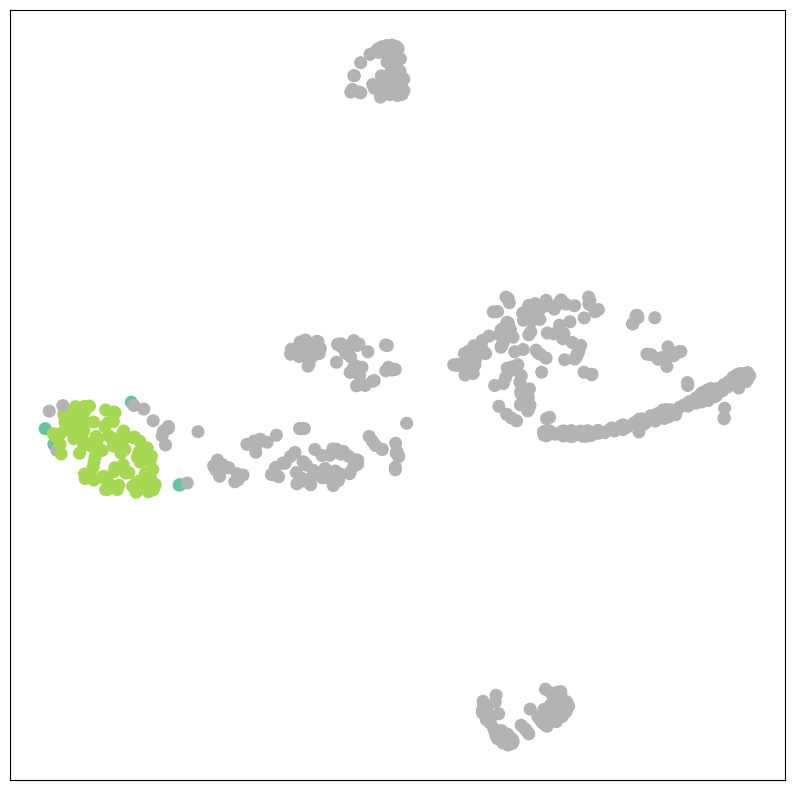

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    # z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

visualize(df3_vectors, color)

手动标注的币安的地址和余弦相似度高的地址在 TSNE 可视化里是聚集在一起的，说明由 `feature_columns` 表示的地址有一些共同的特征，并且在高维的特征空间和低维的可视化空间都能体现出来。

在 dune 上查 `top_100_add_l` 的前 10 个地址的 label

```sql
SELECT
    address,
    ARRAY_JOIN(ARRAY_AGG(name), ';') AS labels,
    ARRAY_JOIN(ARRAY_AGG(category), ';') AS categories
FROM
    labels.addresses
WHERE
    address IN (
        0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b,
        0x0b8a49d816cc709b6eadb09498030ae3416b66dc,
        0x22b260f76f77f8dcd43070e58741c584708e07a5,
        0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,
        0x227139a594ce88d957d561cfecf2bb266cdacc36,
        0x0e464efa2a2d1ddea113ded88a6a2b7b380c1cfe,
        0xb7aca49a098807bdd7851a9b963eac83634063e4,
        0x4c0ad502dab7aed3fd787d2332d4aca49eec77cd,
        0x1d2a9df4e0d5f0493daeda94f589f00697c40f9d,
        0x435664008f38b0650fbc1c9fc971d0a3bc2f1e47
    )
    AND blockchain='ethereum'
GROUP BY
    address
```

`01J72MQXVKA773BXA4Z7FHA3Z1.csv`

In [10]:
!gdown "1j6hcqJakqtoX7M4kh1DN3V6wYm7C3Ozz"
!ls
similar_df = pd.read_csv("01J72MQXVKA773BXA4Z7FHA3Z1.csv")
similar_df.head()

Downloading...
From: https://drive.google.com/uc?id=1j6hcqJakqtoX7M4kh1DN3V6wYm7C3Ozz
To: /content/01J72MQXVKA773BXA4Z7FHA3Z1.csv
100% 1.82k/1.82k [00:00<00:00, 7.97MB/s]
01J6RNZNPCBAPA7HMZ7AE9CCHQ.csv	01J72MQXVKA773BXA4Z7FHA3Z1.csv	sample_data


,address,labels,categories
0,0x1d2a9df4e0d5f0493daeda94f589f00697c40f9d,"Number of DEXs traded on: 2;Paraswap, Uniswap ...",dex;dex;dex;dex;dex;dex;dex
1,0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b,"0x API, 1inch, Uniswap, 1inch-LOP, Curve, Bala...",dex;dex;dex;dex;dex;dex;dex;dex
2,0x0b8a49d816cc709b6eadb09498030ae3416b66dc,"1 year old DEX trader;DEX Trader;0x API, 1inch...",dex;dex;dex;dex;dex;dex;dex;dex
3,0x435664008f38b0650fbc1c9fc971d0a3bc2f1e47,"Uniswap_v3: Pair;Daily Trader;Uniswap, Maveric...",contracts;dex;dex;dex;dex;dex;dex;dex
4,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,"Number of DEXs traded on: 8;Uniswap, Defiswap,...",dex;dex;dex;contracts;dex;dex;dex;dex


## 结论
和币安地址计算的余弦相似度高的基本都是交易所的地址。在 TSNE 可视化图里面也能看到，币安地址和相似度高的地址也是聚集在一起的。用 `feature_columns` 计算的余弦相似度能区分出同一类的地址，比如都是交易所的，但没法区分是否是币安交易所还是其他交易所。

TSNE 可视化里聚在一起的其他簇应该也具有相似类别。

## 参考
- [相似地址发现](https://github.com/rayhopf/bxgu/blob/main/notes/240824_find_similar_address_v001.md)